In [1]:
from sympy import init_printing; init_printing()
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # display all expression in one cell instead of the last one

## Initialization of Variables

In [2]:
from sympy.abc import x
from sympy import integrate, Eq, symbols, Array, Function
from sinupy.algebra.tensor import cross
E_x, E_y, E_z = symbols("E_x, E_y, E_z", real=True); E = Array([E_x, E_y, E_z]) # Array([E_x, E_y, E_z]) or Array([E_x, 0, 0])
B_x, B_y, B_z = symbols("B_x, B_y, B_z", real=True); B = Array([B_x, B_y, B_z]) # Array([B_x, B_y, B_z]) or Array([0, 0, B_z])
t = symbols("t", real=True)
E; B; t
r_x, r_y, r_z = [f(t) for f in symbols("r_x, r_y, r_z", real=True, cls=Function)]; r = Array([r_x, r_y, r_z])
v_x, v_y, v_z = [f(t) for f in symbols("v_x, v_y, v_z", real=True, cls=Function)]; v = Array([v_x, v_y, v_z])

/home/wenyin/pyvenv/vsym/lib/python3.7/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/wenyin/pyvenv/vsym/lib/python3.7/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/wenyin/pyvenv/vsym/lib/python3.7/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/wenyin/pyvenv/vsym/lib/python3.7/site-packages/IPython/lib/latextools.py:126: Matpl

[Eₓ  E_y  E_z]

[Bₓ  B_y  B_z]

## Utility Functions

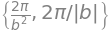

In [3]:
def divide_Array_Eq(eq):
    from sympy import Eq
    assert(eq.lhs.shape == eq.rhs.shape)
    eq_shape = eq.lhs.shape
    arr_order = len(eq_shape) 
    if arr_order > 1: # Not yet tested for high order tensor
        eq_list = []
        for i in range(eq_shape[0]):
            eq_list.append(
                divide_Array_Eq(Eq(eq.lhs[i], eq.rhs[i]))
            )
        return eq_list
    elif arr_order == 1:
        return [Eq(eq.lhs[i], eq.rhs[i]) for i in range(eq_shape[0])]
    else:# arr_order == 0
        return eq

    
def find_trig_period(expr, var):
#     from collections.abc import Iterable
#     if isinstance(var, Iterable):
#         return {find_trig_omega(expr, a_var) for a_var in var}
    from sympy.functions.elementary.trigonometric import TrigonometricFunction
    if isinstance(expr, TrigonometricFunction):
        try:
            return {expr.period(symbol=var)}
        except:
            return set()
    else:
        periods = [find_trig_period(sub_expr, var) for sub_expr in expr.args]
        return set().union(*periods)
    
def pick_min_period(expr, t):
    Ts = find_trig_period(expr, t)
    if len(Ts) == 0:
        raise ValueError("The expression does not contain Trigonometric functions, please decide the T parameter manually.")
    try:
        return min(Ts)
    except TypeError: # If we can not decide which period is the min one, a random one is chosen.
        return next(iter(Ts))
    
def time_average_of_TrigFunc(expr, t, method="Integrate_Then_Average", T=None):
    
    if method=="Integrate_Then_Average":
        from sympy import integrate
        
        if T is None:
            T = pick_min_period(expr, t)
        return integrate(expr, (t, 0, T)) / T
#     elif method=="Expand_Multiple_Angle_Then_Subs":
#         raise NotImplementedError(f"{__name__} not yet implemented for the method '{method}'.")
    else:
        raise ValueError(f"The `method` parameter can only be 'Integrate_Then_Average' right now.")

if __name__ == '__main__': # Code for test
    from sympy import sin, sinh, pi, symbols
    a = symbols("a", positive=True)
    b, t = symbols("b, t", real=True)
    find_trig_period(sin((b**2)*t)+sin(b*t), t)

## Set up the Newton Second Law Equation (ode system)

In [4]:
import sympy.solvers.ode as ode

                                                                              
[-B_y⋅v_z(t) + B_z⋅v_y(t) + Eₓ  Bₓ⋅v_z(t) - B_z⋅vₓ(t) + E_y  -Bₓ⋅v_y(t) + B_y⋅
                                                                              

               ⎡d          d           d         ⎤
vₓ(t) + E_z] = ⎢──(vₓ(t))  ──(v_y(t))  ──(v_z(t))⎥
               ⎣dt         dt          dt        ⎦

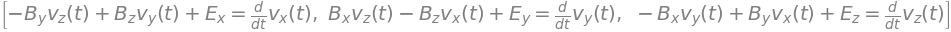

In [5]:
Newton2 = Eq(E + cross(v, B), v.diff(t) ); Newton2
divide_Array_Eq(Newton2)

In [6]:
from sympy import simplify, sqrt
v_sol = ode.systems.dsolve_system(
    divide_Array_Eq(Newton2))

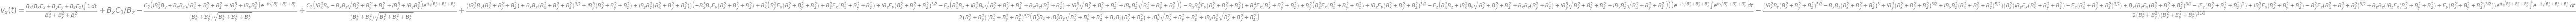

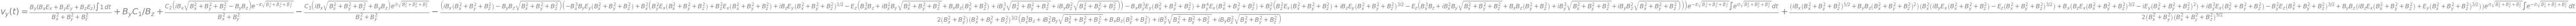

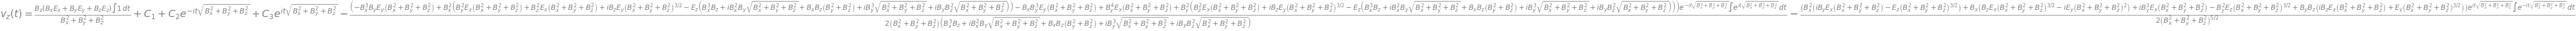

In [7]:
v_sol[0][0]; v_sol[0][1]; v_sol[0][2]

In [ ]:
# The substitutions are for E=[E_x, E_y, E_z], B=[B_x, B_y, B_z] configurations.
from sympy import cos
B_amp, E_amp,theta = symbols("B_{amp}, E_{amp}, theta", real=True)
v_simp_sol = [ [comp_sol\
                .subs(sqrt(B_x**2 + B_y**2 + B_z**2), B_amp)\
                .subs(B_x**2 + B_y**2 + B_z**2, B_amp**2)\
                .subs(B_x*E_x + B_y*E_y + B_z*E_z, B_amp*E_amp*cos(theta)) for comp_sol in v_sol[0]] ]

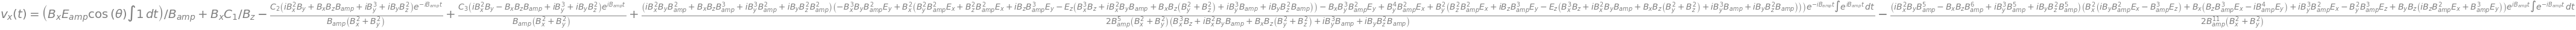

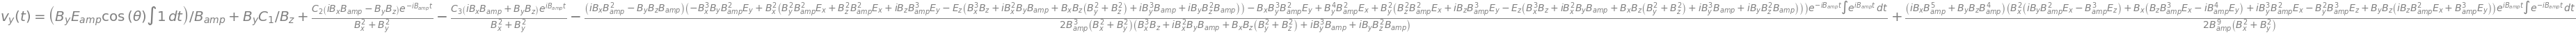

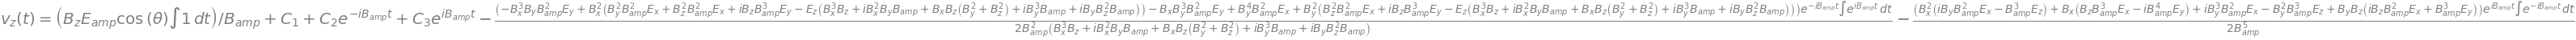

In [13]:
# v_simp_sol = [ [comp_sol.simplify() for comp_sol in v_sol[0] ] ]
for i in range(3): v_simp_sol[0][i]

### Time Averaging

                       ⎛⎧        ⎛2⋅π⋅B_z⎞               ⎛2⋅π⋅B_z⎞         2⎛2
                       ⎜⎪  C₁⋅cos⎜───────⎟         C₂⋅sin⎜───────⎟   Eₓ⋅sin ⎜─
                       ⎜⎪        ⎝ │B_z│ ⎠    C₁         ⎝ │B_z│ ⎠          ⎝ 
                       ⎜⎪- ─────────────── + ─── + ─────────────── + ─────────
                       ⎜⎪        B_z         B_z         B_z                  
                       ⎜⎪                                                 2⋅B_
       2⋅π             ⎜⎨                                                     
      ─────            ⎜⎪                                                2    
      │B_z│            ⎜⎪                                    2⋅π⋅C₂   2⋅π ⋅Eₓ 
        ⌠              ⎜⎪                                    ────── + ─────── 
│B_z│⋅  ⎮   vₓ(t) dt   ⎜⎪                                    │B_z│         2  
        ⌡              ⎜⎪                                               B_z   
        0              ⎝⎩                           

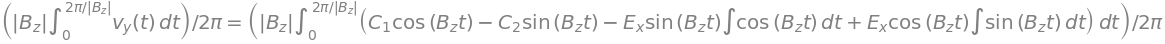

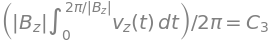

The above formulas look too cumbersome, let's simplify them.


    2⋅π                                   
    ───                                   
    B_z                                   
     ⌠                                    
B_z⋅ ⎮  vₓ(t) dt                          
     ⌡             ⎧    0      for B_z ≠ 0
     0             ⎪                      
──────────────── = ⎨     π⋅Eₓ             
      2⋅π          ⎪C₂ + ────   otherwise 
                   ⎩     B_z              

    2⋅π                               
    ───                               
    B_z                               
     ⌠                                
B_z⋅ ⎮  v_y(t) dt                     
     ⌡              ⎧-Eₓ              
     0              ⎪────  for B_z ≠ 0
───────────────── = ⎨B_z              
       2⋅π          ⎪                 
                    ⎩ C₁    otherwise 

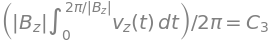

In [28]:
from sympy import simplify, trigsimp
T = pick_min_period(sol[0][0].rhs, t)
t_avg_EqSol = lambda eq: Eq(
    time_average_of_TrigFunc(eq.lhs, t, T=T),
    time_average_of_TrigFunc(eq.rhs, t, T=T))

t_avg_EqSol(sol[0][0])
t_avg_EqSol(sol[0][1])
t_avg_EqSol(sol[0][2])
print("The above formulas look too cumbersome, let's simplify them.")
from sympy import Q, refine
refine(trigsimp(t_avg_EqSol(sol[0][0]).simplify(), method="fu"), Q.positive(B_z))
refine(trigsimp(t_avg_EqSol(sol[0][1]).simplify(), method="fu"), Q.positive(B_z))
t_avg_EqSol(sol[0][2])

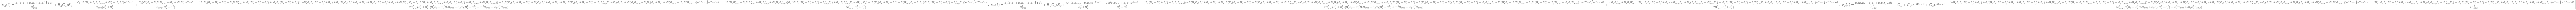

In [17]:
sol

## Fast Lambdify by Cupy 

In [ ]:
import cupy as cp

## Bugs to be reported to Sympy

In [2]:
from sympy import sin, sinh, pi, symbols
a = symbols("a", positive=True)
b, t = symbols("b, t", real=True)
sin(a*t).period(t)

2*pi/a

In [3]:
sin(-a*t).period(t) # AttributeError: 'Mul' object has no attribute 'period'
sin((-1)*a*t).period(t) # AttributeError: 'Mul' object has no attribute 'period'

AttributeError: 'Mul' object has no attribute 'period'

In [4]:
sin(b*t).period(t)

2*pi/Abs(b)